<a href="https://colab.research.google.com/github/shub0411/Book_Recommendation_System/blob/main/book_recommedation_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Book Recommendation System**

# Introduction
During the last few decades, recommender systems have taken more and more place in our lives. From e-commerce to online advertisement, recommender systems are today unavoidable in our daily online journeys.


In a very general way, recommender systems are algorithms aimed at suggesting relevant items to users. Recommender systems are really critical in some industries as they can generate a huge amount of income when they are efficient or also be a way to stand out significantly from competitors. The main objective is to create a book recommendation system for users.

# Data Description
The Book-Crossing dataset comprises 3 files.

## ● Users

Contains the users. Note that user IDs (User-ID) have been anonymized and map to integers. Demographic data is provided (Location, Age) if available. Otherwise, these fields contain NULL values.

## ● Books

Books are identified by their respective ISBN. Invalid ISBNs have already been removed from the dataset. Moreover, some content-based information is given (Book-Title,Book-Author, Year-Of-Publication, Publisher), obtained from Amazon Web Services. Note that in the case of several authors, only the first is provided. URLs linking to cover images are also given, appearing in three different flavors (Image-URL-S,Image-URL-M, Image-URL-L), i.e., small, medium, large. These URLs point to the Amazon website.

## ● Ratings 

Contains the book rating information. Ratings (Book-Rating) are either explicit, expressed on a scale from 1-10 (higher values denoting higher appreciation), or implicit, expressed by 0.

In [1]:
#importing required libraries
import re
import pickle
import operator
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from scipy.sparse import csr_matrix
from pandas.api.types import is_numeric_dtype
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings("ignore")

# Mount drive to colab notebook

In [2]:
#mounting drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading data from csv file to dataframe

# **BOOKS DATASET**

In [5]:
# CSV file loaction path
df_books = pd.read_csv('/content/drive/MyDrive/capstone project 4/data_Books.csv',  error_bad_lines=False, encoding='ISO-8859-1', warn_bad_lines=False)
df_ratings = pd.read_csv('/content/drive/MyDrive/capstone project 4/data_Ratings.csv',error_bad_lines=False, encoding='ISO-8859-1', warn_bad_lines=False)
df_user = pd.read_csv('/content/drive/MyDrive/capstone project 4/data_Users.csv', error_bad_lines=False, encoding='ISO-8859-1', warn_bad_lines=False)

In [6]:
# Check 1st Five rows
df_books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [7]:
# different columns name
df_books.columns

Index(['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher',
       'Image-URL-S', 'Image-URL-M', 'Image-URL-L'],
      dtype='object')

In [8]:
# Check the info of dataset to know the data types of columns or variable
df_books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271359 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


In [9]:
## Check the Summary of Bike data to egt mean,max,25%,50%,75% etc
df_books.describe()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
count,271360,271360,271359,271360,271358,271360,271360,271357
unique,271360,242135,102023,202,16807,271044,271044,271041
top,0195153448,Selected Poems,Agatha Christie,2002,Harlequin,http://images.amazon.com/images/P/185326119X.0...,http://images.amazon.com/images/P/185326119X.0...,http://images.amazon.com/images/P/225307649X.0...
freq,1,27,632,13903,7535,2,2,2


In [10]:
# SHAPE OF THE DATASET
df_books.shape

(271360, 8)

In [11]:
# check for Null values in our bike data
# as we can see we don't have any null values.
df_books.isna().sum()
df_books.isnull().sum()

ISBN                   0
Book-Title             0
Book-Author            1
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64

In [12]:
# drop the id column which is not releavent to dataset and replace the '-' into '_' and also change upper case to lower case
df_books.drop(['Image-URL-S','Image-URL-M','Image-URL-L'], axis= 1, inplace= True)
df_books.columns= df_books.columns.str.strip().str.lower().str.replace('-', '_')
df_user.columns= df_user.columns.str.strip().str.lower().str.replace('-', '_')
df_ratings.columns= df_ratings.columns.str.strip().str.lower().str.replace('-', '_')

In [13]:
# Check 1st Five rows
df_books.head()

,isbn,book_title,book_author,year_of_publication,publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


In [14]:
pd.set_option('display.max_colwidth', -1)

In [15]:
print(df_books.dtypes)
print('-'*40)
print(df_books.isnull().sum())

isbn                   object
book_title             object
book_author            object
year_of_publication    object
publisher              object
dtype: object
----------------------------------------
isbn                   0
book_title             0
book_author            1
year_of_publication    0
publisher              2
dtype: int64


In [16]:
#Let's take care of the missing value in 'book_author' column.
df_books.loc[(df_books['book_author'].isnull()),:]

,isbn,book_title,book_author,year_of_publication,publisher
187689,9627982032,The Credit Suisse Guide to Managing Your Personal Wealth,NaN,1995,Edinburgh Financial Publishing


In [17]:
#replace NAN value with other
df_books.loc[(df_books['isbn'] == '9627982032'),'book_author'] = 'Other'

In [18]:
#Let's look at the unique years to realize the time period as this dataset was created in 2004.
df_books['year_of_publication'].unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 0, 1968, 1961, 1958, 1974,
       1976, 1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960,
       1966, 1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954,
       1950, 1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011,
       1925, 1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030,
       1911, 1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934,
       1910, 1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901,
       2010, 1908, 1906, 1935, 1806, 2021, '2000', '1995', '1999', '2004',
       '2003', '1990', '1994', '1986', '1989', '2002', '1981', '1993',
       '1983', '1982', '1976', '1991', '1977', '1998', '1992', '1996',
       '0', '1997', '2001', '1974', '1968', '1987', '1984', '1988',
       '1963', '1956', '1970', '1985', '1978', '1973', '1980'

We can see there are three string values in the 'year_of_publication' column. Let's check at the corresponding rows in the dataframe.

In [19]:
df_books[df_books['year_of_publication'] == 'DK Publishing Inc'] 

,isbn,book_title,book_author,year_of_publication,publisher
209538,078946697X,"DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)\"";Michael Teitelbaum""",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.01.THUMBZZZ.jpg
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)\"";James Buckley""",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.01.THUMBZZZ.jpg


In [20]:
df_books[df_books['year_of_publication'] == 'Gallimard'] 

,isbn,book_title,book_author,year_of_publication,publisher
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-Marie Gustave Le ClÃ?ÃÂ©zio""",2003,Gallimard,http://images.amazon.com/images/P/2070426769.01.THUMBZZZ.jpg


Persumably there has been a shift in the values of this three rows. Let's bring them in the right place.

In [21]:
def replace_df_value(df, idx, col_name, val):
    df.loc[idx, col_name] = val
    return df

In [22]:
#shift the changes from  dataset
replace_df_value(df_books, 209538, 'book_title', 'DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)')
replace_df_value(df_books, 209538, 'book_author', 'Michael Teitelbaum')
replace_df_value(df_books, 209538, 'year_of_publication', 2000)
replace_df_value(df_books, 209538, 'publisher', 'DK Publishing Inc')

replace_df_value(df_books, 221678, 'book_title', 'DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)')
replace_df_value(df_books, 221678, 'book_author', 'James Buckley')
replace_df_value(df_books, 221678, 'year_of_publication', 2000)
replace_df_value(df_books, 221678, 'publisher', 'DK Publishing Inc')

replace_df_value(df_books, 220731,'book_title', "Peuple du ciel, suivi de 'Les Bergers")
replace_df_value(df_books, 220731, 'book_author', 'Jean-Marie Gustave Le ClÃ?Â©zio')
replace_df_value(df_books, 220731, 'year_of_publication', 2003)
replace_df_value(df_books, 220731, 'publisher', 'Gallimard')


,isbn,book_title,book_author,year_of_publication,publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company
...,...,...,...,...,...
271355,0440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm)
271356,0525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books
271357,006008667X,Lily Dale : The True Story of the Town that Talks to the Dead,Christine Wicker,2004,HarperSanFrancisco
271358,0192126040,Republic (World's Classics),Plato,1996,Oxford University Press


In [23]:
#Let's check if the corrections are made properly.
df_books.loc[221678]

isbn                   0789466953                                                                                
book_title             DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)
book_author            James Buckley                                                                             
year_of_publication    2000                                                                                      
publisher              DK Publishing Inc                                                                         
Name: 221678, dtype: object

In [24]:
#Let's check if the corrections are made properly.
df_books.loc[209538]

isbn                   078946697X                                                                    
book_title             DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)
book_author            Michael Teitelbaum                                                            
year_of_publication    2000                                                                          
publisher              DK Publishing Inc                                                             
Name: 209538, dtype: object

In [25]:
#locate the isbn ends with X
df_books.loc[df_books['isbn'].str.endswith('X')].head()

,isbn,book_title,book_author,year_of_publication,publisher
9,074322678X,Where You'll Find Me: And Other Stories,Ann Beattie,2002,Scribner
11,080652121X,Hitler's Secret Bankers: The Myth of Swiss Neutrality During the Holocaust,Adam Lebor,2000,Citadel Press
40,038078243X,Miss Zukas and the Raven's Dance,Jo Dereske,1996,Avon
41,055321215X,Pride and Prejudice,Jane Austen,1983,Bantam
42,067176537X,The Therapeutic Touch: How to Use Your Hands to Help or to Heal,Dolores Krieger,1979,Fireside


In [26]:
#Titles with more than 1, ISBN code
df_books[df_books['book_title'] == "Where You'll Find Me: And Other Stories"]

,isbn,book_title,book_author,year_of_publication,publisher
9,074322678X,Where You'll Find Me: And Other Stories,Ann Beattie,2002,Scribner
213486,0684815109,Where You'll Find Me: And Other Stories,Ann Beattie,1996,Scribner Book Company


In [27]:
#AGAIN check the null values
df_books.isnull().sum()

isbn                   0
book_title             0
book_author            0
year_of_publication    0
publisher              2
dtype: int64

So the corrections are made. We've seen there are two missing values in the 'publisher' column. Let's take care of that

In [28]:
df_books.loc[(df_books['publisher'].isnull()),: ]

,isbn,book_title,book_author,year_of_publication,publisher
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN
129037,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN


In [29]:
#replace NAN value with No mention
df_books.loc[(df_books['isbn'] == '193169656X'),'publisher'] = 'No Mention'
df_books.loc[(df_books['isbn'] == '1931696993'),'publisher'] = 'No Mention'

In [30]:
#checking if any null value is still present or not
df_books.isnull().sum()

isbn                   0
book_title             0
book_author            0
year_of_publication    0
publisher              0
dtype: int64

In [31]:
## Converting year of publication in Numbers
df_books['year_of_publication'] = df_books['year_of_publication'].astype(int)

In [32]:
print(sorted(list(df_books['year_of_publication'].unique())))

[0, 1376, 1378, 1806, 1897, 1900, 1901, 1902, 1904, 1906, 1908, 1909, 1910, 1911, 1914, 1917, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2008, 2010, 2011, 2012, 2020, 2021, 2024, 2026, 2030, 2037, 2038, 2050]


In [33]:
## Replacing Invalid years with max year
count = Counter(df_books['year_of_publication'])
[k for k, v in count.items() if v == max(count.values())]

[2002]

Counter is a subclass of dict that's specially designed for counting hashable objects in Python.

In [34]:
df_books.loc[df_books['year_of_publication'] > 2021, 'year_of_publication'] = 2002
df_books.loc[df_books['year_of_publication'] == 0, 'year_of_publication'] = 2002

In [35]:
## Uppercasing all alphabets in ISBN
df_books['isbn'] = df_books['isbn'].str.upper()

In [36]:
## Drop duplicate rows
df_books.drop_duplicates(keep='last', inplace=True) 
df_books.reset_index(drop = True, inplace = True)

In [37]:
#check the dtype of dataset
df_books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271047 entries, 0 to 271046
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   isbn                 271047 non-null  object
 1   book_title           271047 non-null  object
 2   book_author          271047 non-null  object
 3   year_of_publication  271047 non-null  int64 
 4   publisher            271047 non-null  object
dtypes: int64(1), object(4)
memory usage: 10.3+ MB


# **For Users Dataset** 

In [38]:
#first five set of user dataset and columns name
print("Columns: ", list(df_user.columns))
df_user.head()

Columns:  ['user_id', 'location', 'age']


,user_id,location,age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [39]:
#checking for null values
df_user.isnull().sum()

user_id     0     
location    0     
age         110762
dtype: int64

In [40]:
#shape of user dataset
df_user.shape

(278858, 3)

In [41]:
## Check for all unique values present in Age column
print(list(sorted(df_user['age'].unique())))

[nan, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 113.0, 114.0, 115.0, 116.0, 118.0, 119.0, 123.0, 124.0, 127.0, 128.0, 132.0, 133.0, 136.0, 137.0, 138.0, 140.0, 141.0, 143.0, 146.0, 147.0, 148.0, 151.0, 152.0, 156.0, 157.0, 159.0, 162.0, 168.0, 172.0, 175.0, 183.0, 186.0, 189.0, 199.0, 200.0, 201.0, 204.0, 207.0, 208.0, 209.0, 210.0, 212.0, 219.0, 220.0, 223.0, 226.0

By keeping the valid age range of readers as 10 to 80 replace null values and invalid ages in the Age column with the mean of valid ages.

In [42]:
required = df_user[df_user['age'] <= 80]
required = required[required['age'] >= 10]

In [43]:
#mean of age column
mean = round(required['age'].mean())   
mean

35

In [44]:
#substituted the mean value in place of age values greater than 80 and less than 10
df_user.loc[df_user['age'] > 80, 'age'] = mean    #outliers with age grater than 80 are substituted with mean 
df_user.loc[df_user['age'] < 10, 'age'] = mean    #outliers with age less than 10 years are substitued with mean


In [45]:
#filling null values with mean
df_user['age'] = df_user['age'].fillna(mean)      
#changing Datatype to int
df_user['age'] = df_user['age'].astype(int)       

The location column has 3 values city, state, and country. These are split into 3 different columns named; City, State, and Country respectively. In the case of null value, ‘other’ has been assigned as the entity value.

In [46]:
#spliting the dataset into new three columns
list_ = df_user.location.str.split(', ')

city = []
state = []
country = []
count_no_state = 0    
count_no_country = 0

for i in range(0,len(list_)):
    if list_[i][0] == ' ' or list_[i][0] == '' or list_[i][0]=='n/a' or list_[i][0] == ',':  #removing invalid entries too
        city.append('other')
    else:
        city.append(list_[i][0].lower())

    if(len(list_[i])<2):
        state.append('other')
        country.append('other')
        count_no_state += 1
        count_no_country += 1
    else:
        if list_[i][1] == ' ' or list_[i][1] == '' or list_[i][1]=='n/a' or list_[i][1] == ',':   #removing invalid entries 
            state.append('other')
            count_no_state += 1            
        else:
            state.append(list_[i][1].lower())
        
        if(len(list_[i])<3):
            country.append('other')
            count_no_country += 1
        else:
            if list_[i][2] == ''or list_[i][1] == ',' or list_[i][2] == ' ' or list_[i][2] == 'n/a':
                country.append('other')
                count_no_country += 1
            else:
                country.append(list_[i][2].lower())
        
df_user = df_user.drop('location',axis=1)

temp = []
for ent in city:
    c = ent.split('/')            #handling cases where city/state entries from city list as state is already given 
    temp.append(c[0])

df_city = pd.DataFrame(temp,columns=['city'])
df_state = pd.DataFrame(state,columns=['state'])
df_country = pd.DataFrame(country,columns=['country'])

df_user = pd.concat([df_user, df_city], axis=1)
df_user = pd.concat([df_user, df_state], axis=1)
df_user = pd.concat([df_user, df_country], axis=1)

print(count_no_country)   #printing the number of countries didnt have any values 
print(count_no_state)     #printing the states which didnt have any values

4659
16044


In [47]:
## Drop duplicate rows
df_user.drop_duplicates(keep='last', inplace=True)
df_user.reset_index(drop=True, inplace=True)

In [48]:
#information of dataset
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   user_id  278858 non-null  int64 
 1   age      278858 non-null  int64 
 2   city     278858 non-null  object
 3   state    278858 non-null  object
 4   country  278858 non-null  object
dtypes: int64(2), object(3)
memory usage: 10.6+ MB


In [49]:
#again check the new user dataset
df_user.head()

,user_id,age,city,state,country
0,1,35,nyc,new york,usa
1,2,18,stockton,california,usa
2,3,35,moscow,yukon territory,russia
3,4,17,porto,v.n.gaia,portugal
4,5,35,farnborough,hants,united kingdom


# **For Rating Dataset**

In [50]:
#first five set of user dataset and columns name
print("Columns: ", list(df_ratings.columns))
df_ratings.head()

Columns:  ['user_id', 'isbn', 'book_rating']


,user_id,isbn,book_rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [51]:
## Checking for null values
df_ratings.isnull().sum() 

user_id        0
isbn           0
book_rating    0
dtype: int64

In [52]:
from pandas.api.types import is_numeric_dtype
## checking all ratings number or not
print(is_numeric_dtype(df_ratings['book_rating']))

True


In [53]:
## checking User-ID contains only number or not
print(is_numeric_dtype(df_ratings['user_id']))

True


In [54]:
## checking ISBN
flag = 0
k =[]
reg = "[^A-Za-z0-9]"

for x in df_ratings['isbn']:
    z = re.search(reg,x)    
    if z:
        flag = 1

if flag == 1:
    print("False")
else:
    print("True")

False


In [55]:
## removing extra characters from ISBN (from ratings dataset) existing in books dataset
bookISBN = df_books['isbn'].tolist() 
reg = "[^A-Za-z0-9]" 
for index, row_Value in df_ratings.iterrows():
    z = re.search(reg, row_Value['isbn'])    
    if z:
        f = re.sub(reg,"",row_Value['isbn'])
        if f in bookISBN:
            df_ratings.at[index , 'isbn'] = f

In [56]:
## Uppercasing all alphabets in ISBN
df_ratings['isbn'] = df_ratings['isbn'].str.upper()


In [57]:
## Drop duplicate rows
df_ratings.drop_duplicates(keep='last', inplace=True)
df_ratings.reset_index(drop=True, inplace=True)

In [58]:
#infomation on dataset
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149776 entries, 0 to 1149775
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   user_id      1149776 non-null  int64 
 1   isbn         1149776 non-null  object
 2   book_rating  1149776 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [59]:
#again check the new rating dataset
df_ratings.head()

,user_id,isbn,book_rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


# **Merging of all three Tables**

**Merging Books, Users and Rating Tables in One**

In [60]:
#merging the tables
dataset = pd.merge(df_books, df_ratings, on='isbn', how='inner')
dataset = pd.merge(dataset, df_user, on='user_id', how='inner')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1031609 entries, 0 to 1031608
Data columns (total 11 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   isbn                 1031609 non-null  object
 1   book_title           1031609 non-null  object
 2   book_author          1031609 non-null  object
 3   year_of_publication  1031609 non-null  int64 
 4   publisher            1031609 non-null  object
 5   user_id              1031609 non-null  int64 
 6   book_rating          1031609 non-null  int64 
 7   age                  1031609 non-null  int64 
 8   city                 1031609 non-null  object
 9   state                1031609 non-null  object
 10  country              1031609 non-null  object
dtypes: int64(4), object(7)
memory usage: 94.4+ MB


In [61]:
#first 5 set of the dataset
dataset.head()

,isbn,book_title,book_author,year_of_publication,publisher,user_id,book_rating,age,city,state,country
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,2,0,18,stockton,california,usa
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,8,5,35,timmins,ontario,canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,8,0,35,timmins,ontario,canada
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,8,0,35,timmins,ontario,canada
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,8,0,35,timmins,ontario,canada


Divide complete data on the basis of Implicit and Explicit ratings datasets

In [62]:
## Explicit Ratings Dataset 
dataset1 = dataset[dataset['book_rating'] != 0]
dataset1 = dataset1.reset_index(drop = True)
dataset1.shape

(384074, 11)

In [63]:
## Implicit Ratings Dataset
dataset2 = dataset[dataset['book_rating'] == 0]
dataset2 = dataset2.reset_index(drop = True)
dataset2.shape

(647535, 11)

In [64]:
#first 5 set
dataset1.head()

,isbn,book_title,book_author,year_of_publication,publisher,user_id,book_rating,age,city,state,country
0,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,8,5,35,timmins,ontario,canada
1,074322678X,Where You'll Find Me: And Other Stories,Ann Beattie,2002,Scribner,8,5,35,timmins,ontario,canada
2,0887841740,The Middle Stories,Sheila Heti,2004,House of Anansi Press,8,5,35,timmins,ontario,canada
3,1552041778,Jane Doe,R. J. Kaiser,1999,Mira Books,8,5,35,timmins,ontario,canada
4,1567407781,The Witchfinder (Amos Walker Mystery Series),Loren D. Estleman,1998,Brilliance Audio - Trade,8,6,35,timmins,ontario,canada


In [65]:
#first 5 set
dataset2.head()

,isbn,book_title,book_author,year_of_publication,publisher,user_id,book_rating,age,city,state,country
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,2,0,18,stockton,california,usa
1,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,8,0,35,timmins,ontario,canada
2,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,8,0,35,timmins,ontario,canada
3,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,8,0,35,timmins,ontario,canada
4,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,8,0,35,timmins,ontario,canada


# **Data Visualization**

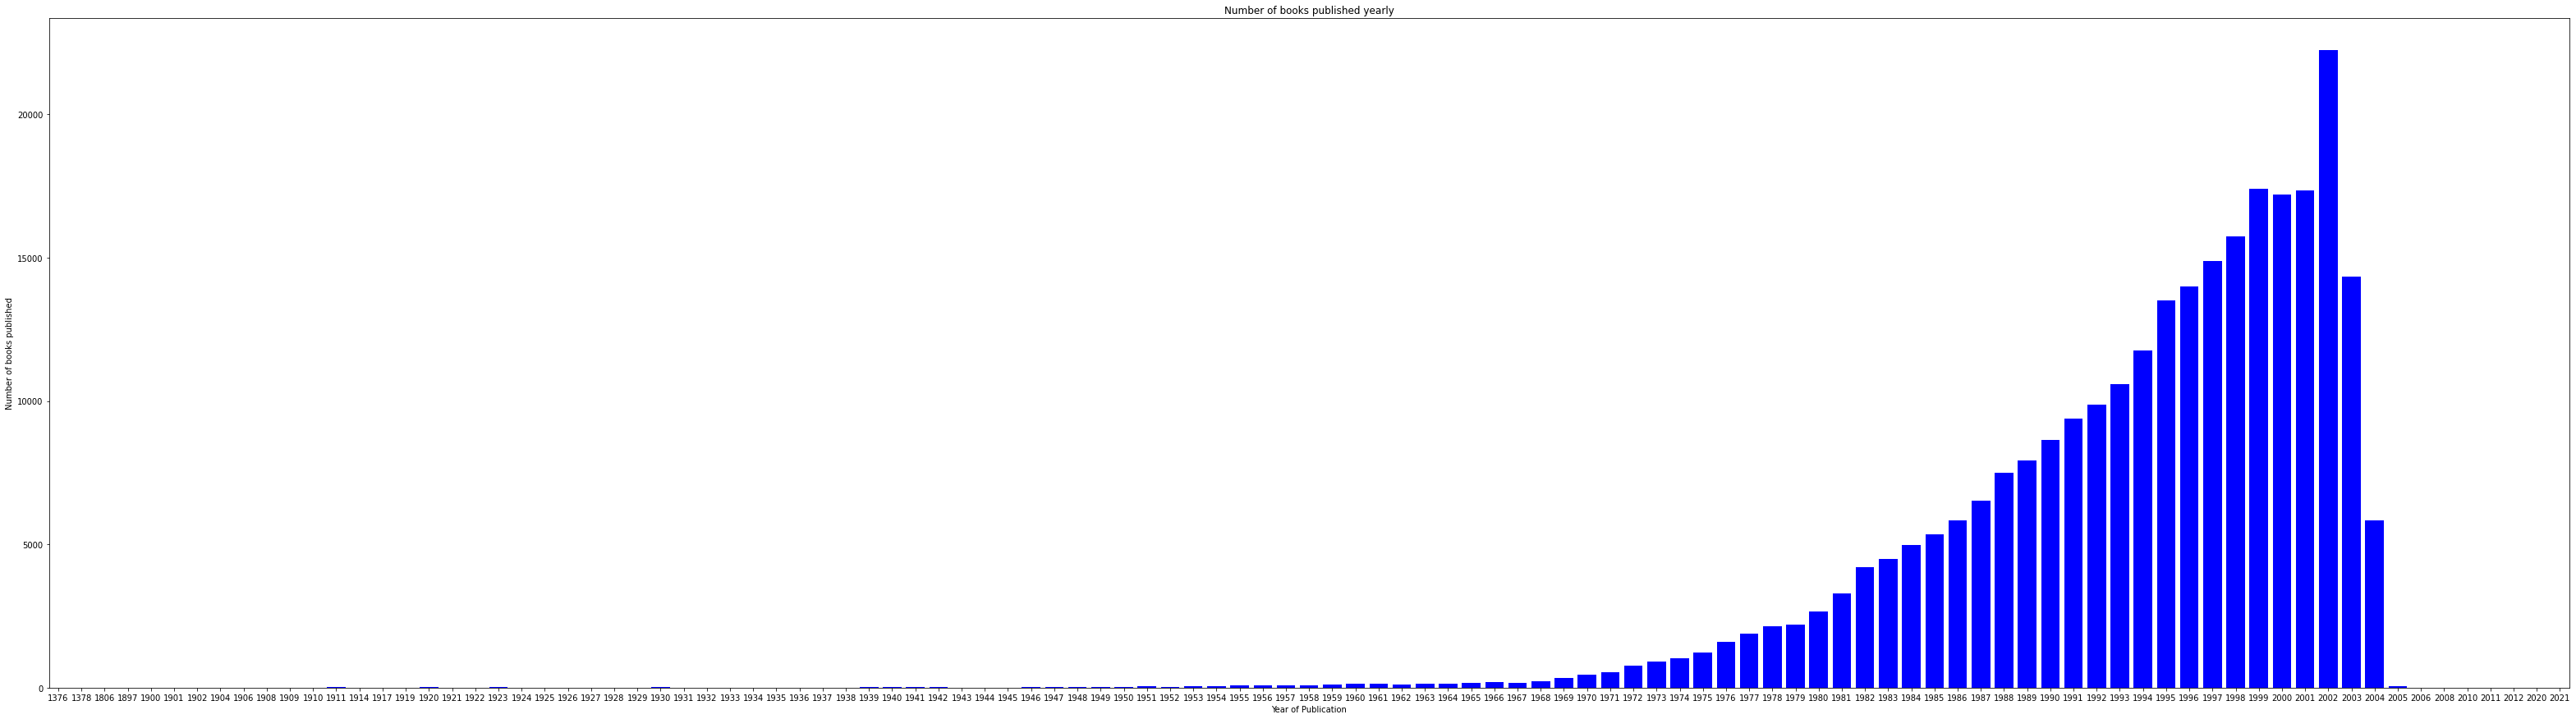

In [66]:
#"Number of books published yearly
publications = {}
for year in df_books['year_of_publication']:
    if str(year) not in publications:
        publications[str(year)] = 0
    publications[str(year)] +=1

publications = {k:v for k, v in sorted(publications.items())}

fig = plt.figure(figsize =(55, 15))
plt.bar(list(publications.keys()),list(publications.values()), color = 'blue')
plt.ylabel("Number of books published")
plt.xlabel("Year of Publication")
plt.title("Number of books published yearly")
plt.margins(x = 0)
plt.show()

Text(0.5, 1.0, 'No of books by an author (Top 15)')

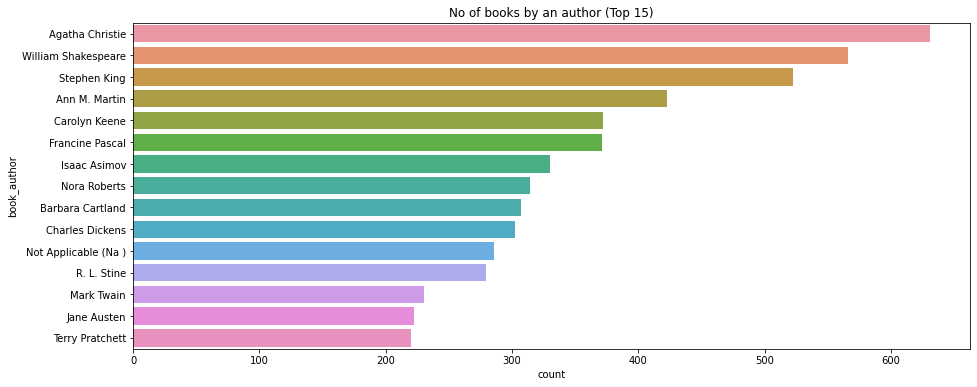

In [67]:
#No of books by an author (Top 15) 
plt.figure(figsize=(15,6))
sns.countplot(y="book_author", data=df_books,order=df_books['book_author'].value_counts().index[0:15])
plt.title("No of books by an author (Top 15)")

Text(0.5, 1.0, 'No of books published by a publisher (Top 15)')

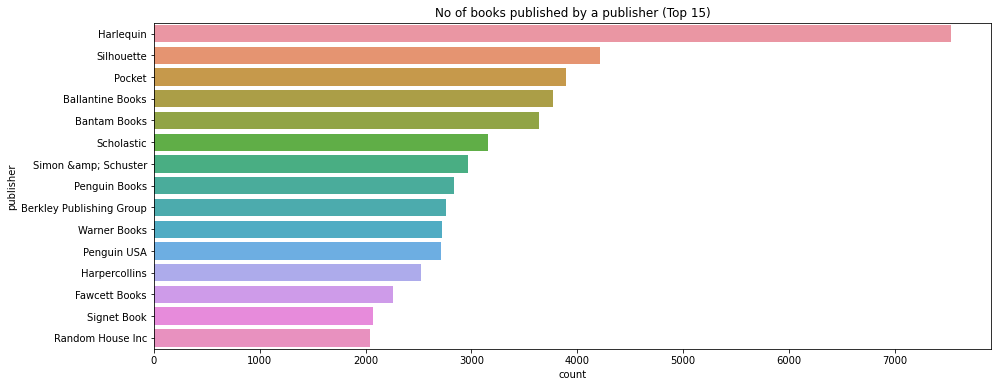

In [68]:
#No of books published by a publisher (Top 15)
plt.figure(figsize=(15,6))
sns.countplot(y="publisher", data=df_books,order=df_books['publisher'].value_counts().index[0:15])
plt.title("No of books published by a publisher (Top 15)")

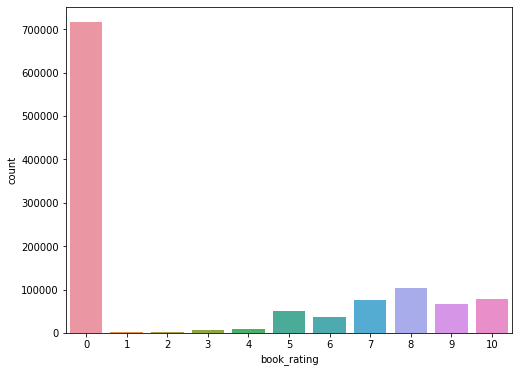

In [69]:
# book rating which include the 0 rating also
plt.figure(figsize=(8,6))
sns.countplot(x="book_rating", data=df_ratings)

This countplot shows users have rated 0 the most, which can mean they haven't rated bokks at all. We have to separate the explicit ratings represented by 1–10 and implicit ratings represented by 0.

Text(0.5, 1.0, 'Explicit Ratings')

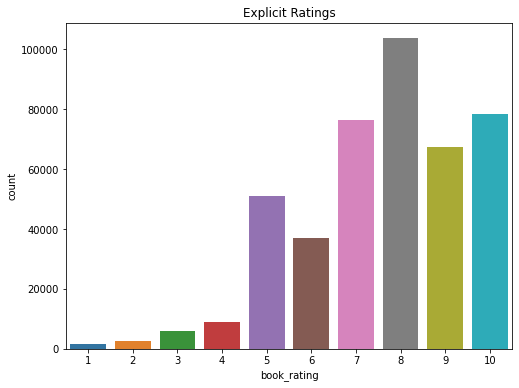

In [70]:
## Explicit Ratings
plt.figure(figsize=(8,6))
data = df_ratings[df_ratings['book_rating'] != 0]
sns.countplot(x="book_rating", data=data)
plt.title("Explicit Ratings")

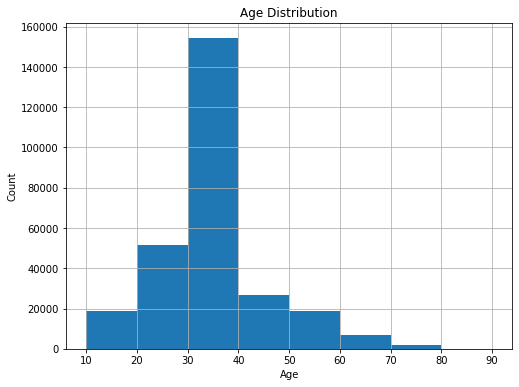

In [71]:
#age distribution 
plt.figure(figsize=(8,6))
df_user.age.hist(bins=[10*i for i in range(1, 10)])     
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

Text(0.5, 1.0, 'No of readers from each city (Top 15)')

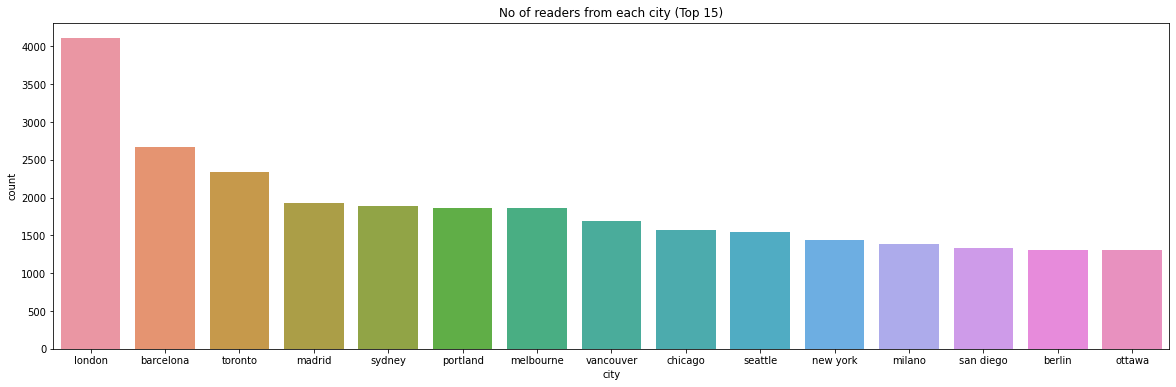

In [72]:
#No of readers from each city (Top 15)
plt.figure(figsize=(20,6))
sns.countplot(x="city", data=df_user,order=df_user['city'].value_counts().index[0:15])
plt.title("No of readers from each city (Top 15)")

Text(0.5, 1.0, 'No of readers from each state (Top 15)')

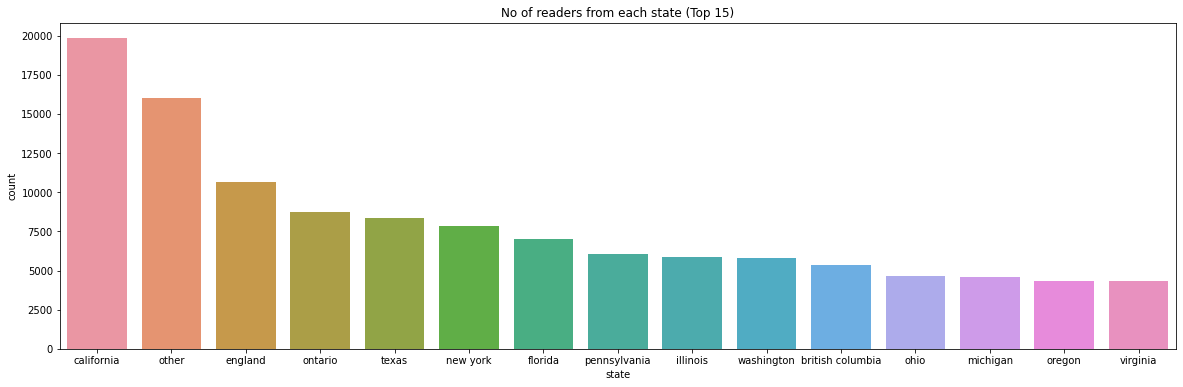

In [73]:
#No of readers from each state (Top 15)
plt.figure(figsize=(20,6))
sns.countplot(x="state", data=df_user,order=df_user['state'].value_counts().index[0:15])
plt.title("No of readers from each state (Top 15)")

Text(0.5, 1.0, 'No of readers from each country (Top 10)')

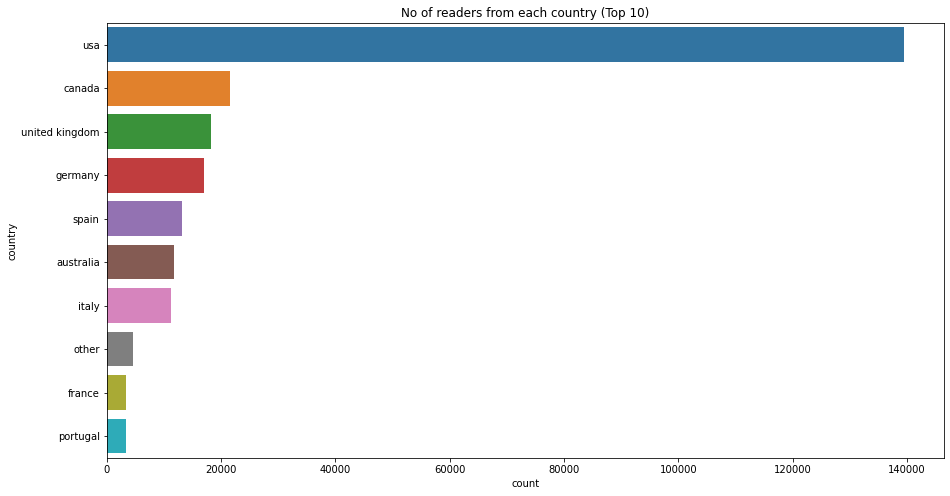

In [74]:
#No of readers from each country (Top 10)
plt.figure(figsize=(15,8))
sns.countplot(y="country", data=df_user, order=df_user['country'].value_counts().index[0:10])
plt.title("No of readers from each country (Top 10)")

Text(0.5, 1.0, 'No of readers from states of USA (Top 15)')

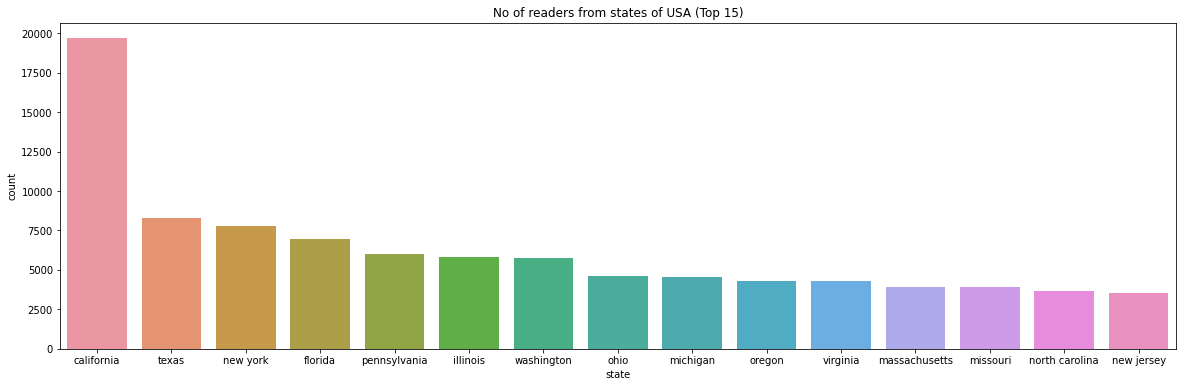

In [75]:
#No of readers from states of USA (Top 15)
data=df_user[df_user['country']=='usa']
plt.figure(figsize=(20,6))
sns.countplot(x="state", data=data,order=data['state'].value_counts().index[0:15])
plt.title("No of readers from states of USA (Top 15)")

Text(0.5, 1.0, 'Number of Ratings for a book (Top 15)')

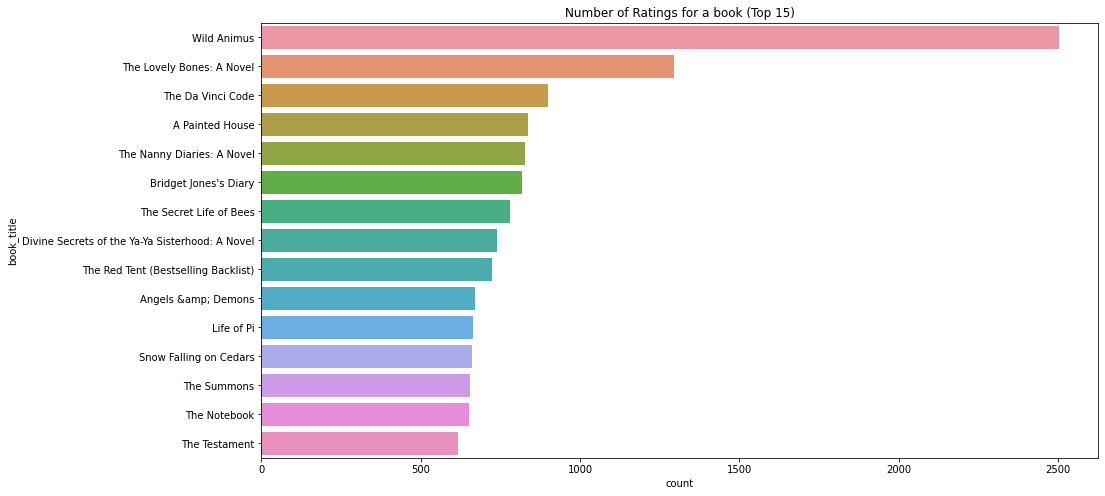

In [76]:
#Number of Ratings for a book (Top 15)
plt.figure(figsize=(15,8))
sns.countplot(y="book_title", data=dataset, order=dataset['book_title'].value_counts().index[0:15])
plt.title("Number of Ratings for a book (Top 15)")

# **Recommendation Systems**

In [77]:
bookName = input("Enter a book name: ")
number = int(input("Enter number of books to recommend: "))

# Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))



Enter a book name: Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))
Enter number of books to recommend: 5


**1. Popularity Based (Top In whole collection)**

In [78]:
#defined a function on grouping the isbn and book rating for the popular books in dataset 
def popularity_based(dataframe, n):
    if n >= 1 and n <= len(dataframe):
        data = pd.DataFrame(dataframe.groupby('isbn')['book_rating'].count()).sort_values('book_rating', ascending=False).head(n)
        result = pd.merge(data,df_books, on='isbn', left_index = False)
        return result
    return "Invalid number of books entered!!"

In [79]:
df_books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271047 entries, 0 to 271046
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   isbn                 271047 non-null  object
 1   book_title           271047 non-null  object
 2   book_author          271047 non-null  object
 3   year_of_publication  271047 non-null  int64 
 4   publisher            271047 non-null  object
dtypes: int64(1), object(4)
memory usage: 10.3+ MB


In [80]:
print("Top", number, "Popular books are: ")
popularity_based(dataset1, number)

Top 5 Popular books are: 


,isbn,book_rating,book_title,book_author,year_of_publication,publisher
0,0316666343,707,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown"
1,0971880107,581,Wild Animus,Rich Shapero,2004,Too Far
2,0385504209,488,The Da Vinci Code,Dan Brown,2003,Doubleday
3,0312195516,383,The Red Tent (Bestselling Backlist),Anita Diamant,1998,Picador USA
4,0060928336,320,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997,Perennial


**2. Popularity Based (Top In a given place)**

In [81]:
#deined a function on the popularity based on the place
def search_unique_places(dataframe, place):
    place = place.lower()

    if place in list(dataframe['city'].unique()):
        return dataframe[dataframe['city'] == place]
    elif place in list(dataframe['state'].unique()):
        return dataframe[dataframe['state'] == place]
    elif place in list(dataframe['country'].unique()):
        return dataframe[dataframe['country'] == place]
    else:
        return "Invalid Entry"

In [82]:
# enter the place you would like to see
place = input("Enter the name of place: ")
data = search_unique_places(dataset1, place)

if isinstance(data, pd.DataFrame):
    data = popularity_based(data, number)

data

Enter the name of place: India


,isbn,book_rating,book_title,book_author,year_of_publication,publisher
0,0971880107,3,Wild Animus,Rich Shapero,2004,Too Far
1,0671047612,2,Skin And Bones,Franklin W. Dixon,2000,Aladdin
2,0486284735,2,Pride and Prejudice (Dover Thrift Editions),Jane Austen,1995,Dover Publications
3,8171670407,2,Inscrutable Americans,Mathur Anurag,1996,South Asia Books
4,0006944035,1,Secret Island / Secret Mountain (Two-in-ones),Enid Blyton,1994,HarperCollins Publishers


**3. Books by same author, publisher of given book name**

In [83]:
def printBook(k, n):
    z = k['book_title'].unique()
    for x in range(len(z)):
        print(z[x])
        if x >= n-1:
            break

In [84]:
# define the dataset with booktitle for the same author
def get_books(dataframe, name, n):
    print("\nBooks by same Author:\n")
    au = dataframe['book_author'].unique()

    data = dataset1[dataset1['book_title'] != name]

    if au[0] in list(data['book_author'].unique()):
        k2 = data[data['book_author'] == au[0]]
    k2 = k2.sort_values(by=['book_rating'])
    printBook(k2, n)
# define the dataset with booktitle for the same publisher
    print("\n\nBooks by same Publisher:\n")
    au = dataframe['publisher'].unique()

    if au[0] in list(data['publisher'].unique()):
        k2 = pd.DataFrame(data[data['publisher'] == au[0]])
    k2=k2.sort_values(by=['book_rating']) 
    printBook(k2, n)

In [85]:
if bookName in list(dataset1['book_title'].unique()):
    d = dataset1[dataset1['book_title'] == bookName]
    get_books(d, bookName, number)
else:
    print("Invalid Book Name!!")


Books by same Author:

Harry Potter and the Goblet of Fire (Book 4)
Harry Potter and the Order of the Phoenix (Book 5)
Harry Potter y el cÃÂ¡liz de fuego
Harry Potter and the Chamber of Secrets (Book 2)
Harry Potter and the Sorcerer's Stone (Book 1)


Books by same Publisher:

The Seeing Stone
The Slightly True Story of Cedar B. Hartley: Who Planned to Live an Unusual Life
Harry Potter and the Chamber of Secrets (Harry Potter)
The Story of the Seagull and the Cat Who Taught Her To Fly
Book! Book! Book!


**4. Books popular Yearly**

In [86]:
#most popular book on the basic of the year of publication
data = pd.DataFrame(dataset1.groupby('isbn')['book_rating'].count()).sort_values('book_rating', ascending=False)
data = pd.merge(data,df_books, on='isbn', left_index = False)

years = set()
indices = []
for ind, row in data.iterrows():
    if row['year_of_publication'] in years:
        indices.append(ind)
    else:
        years.add(row['year_of_publication'])

data = data.drop(indices)
data = data.drop('book_rating', axis = 1)
data = data.sort_values('year_of_publication')

pd.set_option("display.max_rows", None, "display.max_columns", None)
data

,isbn,book_title,book_author,year_of_publication,publisher
73895,964442011X,Tasht-i khun,IsmaÃÂ°il Fasih,1376,Nashr-i Alburz
73896,9643112136,Dalan-i bihisht (Dastan-i Irani),Nazi Safavi,1378,Intisharat-i Quqnus
130309,0781228956,"Complete Works 10 Volumes [2,6,7,8,9] (Notable American Authors)",Benjamin Franklin,1806,Reprint Services Corp
81469,1551103982,The Cycling Adventures of Coconut Head: A North American Odyssey,Ted Schredd,1900,Graphic Arts Center Pub Co
125519,0671397214,JOY OF MUSIC P,Leonard Bernstein,1901,Fireside
48634,0373226888,Tommy's Mom,Linda O. Johnston,1902,Harlequin
104339,038528120X,CATCH 22,JOSEPH HELLER,1904,Delta
103193,0404089119,Charlotte Bronte and Her Sisters,Clement K. Shorter,1906,Ams Pr
24664,0911662251,Kybalion: A Study of the Hermetic Philosophy of Ancient Egypt and Greece,Three Initiates,1908,Yoga Publication Society
53807,0892760508,New Birth,Kenneth Hagin,1911,Faith Library Publications


**5. Collaborative Filtering (User-Item Filtering)**

In [87]:
# Selecting books with total ratings equals to or more than 50 (Because of availability of limited resources)
df = pd.DataFrame(dataset1['book_title'].value_counts())
df['total_ratings'] = df['book_title']
df['book_title'] = df.index
df.reset_index(level=0, inplace=True)
df = df.drop('index',axis=1)

df = dataset1.merge(df, left_on = 'book_title', right_on = 'book_title', how = 'left')
df = df.drop(['year_of_publication','publisher','age','city','state','country'], axis=1)

popularity_threshold = 50
popular_book = df[df['total_ratings'] >= popularity_threshold]
popular_book = popular_book.reset_index(drop = True)

User - Item Collaborative Filtering

In [88]:
testdf = pd.DataFrame()
testdf['isbn'] = popular_book['isbn']
testdf['book_rating'] = popular_book['book_rating']
testdf['user_id'] = popular_book['user_id']
testdf = testdf[['user_id','book_rating']].groupby(testdf['isbn'])

In [89]:
listOfDictonaries=[]
indexMap = {}
reverseIndexMap = {}
ptr=0

for groupKey in testdf.groups.keys():
    tempDict={}
    groupDF = testdf.get_group(groupKey)
    for i in range(0,len(groupDF)):
        tempDict[groupDF.iloc[i,0]] = groupDF.iloc[i,1]
    indexMap[ptr]=groupKey
    reverseIndexMap[groupKey] = ptr
    ptr=ptr+1
    listOfDictonaries.append(tempDict)

dictVectorizer = DictVectorizer(sparse=True)
vector = dictVectorizer.fit_transform(listOfDictonaries)
pairwiseSimilarity = cosine_similarity(vector)

In [90]:
def printBookDetails(bookID):
    print(dataset1[dataset1['isbn']==bookID]['book_title'].values[0])
    """
    print("Title:", dataset1[dataset1['ISBN']==bookID]['Book-Title'].values[0])
    print("Author:",dataset1[dataset['ISBN']==bookID]['Book-Author'].values[0])
    #print("Printing Book-ID:",bookID)
    print("\n")
    """

def getTopRecommandations(bookID):
    collaborative = []
    row = reverseIndexMap[bookID]
    print("Input Book:")
    printBookDetails(bookID)
    
    print("\nRECOMMENDATIONS:\n")
    
    mn = 0
    similar = []
    for i in np.argsort(pairwiseSimilarity[row])[:-2][::-1]:
          if dataset1[dataset1['isbn']==indexMap[i]]['book_title'].values[0] not in similar:
                if mn>=number:
                      break
                mn+=1
                similar.append(dataset1[dataset1['isbn']==indexMap[i]]['book_title'].values[0])
                printBookDetails(indexMap[i])
                collaborative.append(dataset1[dataset1['isbn']==indexMap[i]]['book_title'].values[0])
    return collaborative

In [91]:
k = list(dataset1['book_title'])
m = list(dataset1['isbn'])

collaborative = getTopRecommandations(m[k.index(bookName)])

Input Book:
Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))

RECOMMENDATIONS:

Harry Potter and the Prisoner of Azkaban (Book 3)
Harry Potter and the Goblet of Fire (Book 4)
Harry Potter and the Order of the Phoenix (Book 5)
Harry Potter and the Chamber of Secrets (Book 2)
Fried Green Tomatoes at the Whistle Stop Cafe


## **6. Correlation Based**

In [92]:
popularity_threshold = 50

user_count = dataset1['user_id'].value_counts()
data = dataset1[dataset1['user_id'].isin(user_count[user_count >= popularity_threshold].index)]
rat_count = data['book_rating'].value_counts()
data = data[data['book_rating'].isin(rat_count[rat_count >= popularity_threshold].index)]

matrix = data.pivot_table(index='user_id', columns='isbn', values = 'book_rating').fillna(0)

In [93]:
average_rating = pd.DataFrame(dataset1.groupby('isbn')['book_rating'].mean())
average_rating['ratingCount'] = pd.DataFrame(df_ratings.groupby('isbn')['book_rating'].count())
average_rating.sort_values('ratingCount', ascending=False).head()

,book_rating,ratingCount
isbn,,
0971880107,4.390706,2502
0316666343,8.185290,1295
0385504209,8.426230,884
0060928336,7.887500,732
0312195516,8.182768,723


In [94]:
isbn = df_books.loc[df_books['book_title'] == bookName].reset_index(drop = True).iloc[0]['isbn']
row = matrix[isbn]
correlation = pd.DataFrame(matrix.corrwith(row), columns = ['Pearson Corr'])
corr = correlation.join(average_rating['ratingCount'])

res = corr.sort_values('Pearson Corr', ascending=False).head(number+1)[1:].index
corr_books = pd.merge(pd.DataFrame(res, columns = ['isbn']), df_books, on='isbn')
print("\n Recommended Books: \n")
corr_books


 Recommended Books: 



,isbn,book_title,book_author,year_of_publication,publisher
0,0439064872,Harry Potter and the Chamber of Secrets (Book 2),J. K. Rowling,2000,Scholastic
1,0439136369,Harry Potter and the Prisoner of Azkaban (Book 3),J. K. Rowling,2001,Scholastic
2,0439139597,Harry Potter and the Goblet of Fire (Book 4),J. K. Rowling,2000,Scholastic
3,0804115613,Fried Green Tomatoes at the Whistle Stop Cafe,Fannie Flagg,2000,Ballantine Books
4,0439139600,Harry Potter and the Goblet of Fire (Book 4),J. K. Rowling,2002,Scholastic Paperbacks


**7. Nearest Neighbours Based**

In [95]:
data = (dataset1.groupby(by = ['book_title'])['book_rating'].count().reset_index().
        rename(columns = {'book_rating': 'total_rating'})[['book_title', 'total_rating']])

result = pd.merge(data, dataset1, on='book_title', left_index = False)
result = result[result['total_rating'] >= popularity_threshold]
result = result.reset_index(drop = True)

matrix = result.pivot_table(index = 'book_title', columns = 'user_id', values = 'book_rating').fillna(0)
up_matrix = csr_matrix(matrix)

In [96]:
model = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model.fit(up_matrix)

distances, indices = model.kneighbors(matrix.loc[bookName].values.reshape(1, -1), n_neighbors = number+1)
print("\nRecommended books:\n")
for i in range(0, len(distances.flatten())):
    if i > 0:
        print(matrix.index[indices.flatten()[i]])


Recommended books:

Harry Potter and the Chamber of Secrets (Book 2)
Harry Potter and the Prisoner of Azkaban (Book 3)
Harry Potter and the Goblet of Fire (Book 4)
Harry Potter and the Order of the Phoenix (Book 5)
The Fellowship of the Ring (The Lord of the Rings, Part 1)


**8. Content Based**

In [97]:
popularity_threshold = 80
popular_book = df[df['total_ratings'] >= popularity_threshold]
popular_book = popular_book.reset_index(drop = True)
popular_book.shape

(44652, 6)

In [98]:
tf = TfidfVectorizer(ngram_range=(1, 2), min_df = 1, stop_words='english')
tfidf_matrix = tf.fit_transform(popular_book['book_title'])
tfidf_matrix.shape

(44652, 1112)

In [99]:
normalized_df = tfidf_matrix.astype(np.float32)
cosine_similarities = cosine_similarity(normalized_df, normalized_df)
cosine_similarities.shape

(44652, 44652)

In [100]:
print("Recommended Books:\n")
isbn = df_books.loc[df_books['book_title'] == bookName].reset_index(drop = True).iloc[0]['isbn']
content = []

idx = popular_book.index[popular_book['isbn'] == isbn].tolist()[0]
similar_indices = cosine_similarities[idx].argsort()[::-1]
similar_items = []
for i in similar_indices:
    if popular_book['book_title'][i] != bookName and popular_book['book_title'][i] not in similar_items and len(similar_items) < number:
        similar_items.append(popular_book['book_title'][i])
        content.append(popular_book['book_title'][i])

for book in similar_items:
    print(book)

Recommended Books:

Harry Potter and the Sorcerer's Stone (Book 1)
Harry Potter and the Goblet of Fire (Book 4)
Harry Potter and the Chamber of Secrets (Book 2)
Harry Potter and the Prisoner of Azkaban (Book 3)
Harry Potter and the Order of the Phoenix (Book 5)


# **CONCLUSION**






1.   In EDA, the Top-10 most rated books were essentially novels. Books like The Lovely Bone and The Secret Life of Bees were very well perceived.
2.   Majority of the readers were of the age bracket 20-35 and most of them came from North American and European countries namely USA, Canada, UK, Germany and Spain.
3. If we look at the ratings distribution, most of the books have high ratings with maximum books being rated 8. Ratings below 5 are few in number.
Author with the most books was Agatha Christie, William Shakespeare and Stephen King.
4. For modelling, it was observed that for model based collaborative filtering SVD technique worked way better than NMF with lower Mean Absolute Error (MAE) .
Amongst the memory based approach, item-item CF performed better than user-user CF because of lower computation

